In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive
%cd 'Bioinformatics Project'

Mounted at /content/drive
/content/drive/MyDrive
/content/drive/.shortcut-targets-by-id/1M3r0dTc1ZOtYqjXf6O9h_xvcWvCX_IXa/Bioinformatics Project


### Helper Functions

In [65]:
# Helper functions
'''
Conditional Entropy: computes conditional entropy of target cluster
inputs: overlaps = overlapping regions between the clusters (matrix)
        cluster_lengths = list of sizes of each cluster (list, with length size equal to number of clusters?)
        n = denominator of conditional entropy calculation (float, should be log(n)?)
output: conditonal entropy of target cluster (float64)
'''
def ConditionalEntropy(overlap_matrix, cluster_lengths, n):
    cond_entropy = 0
    for i, row in enumerate(overlap_matrix):
        for j, cell in enumerate(row):
            cluster_length = cluster_lengths[j]
            #print('hi:', cell * math.log(cluster_length))
            cond_entropy += cell * math.log(cluster_length)
            if cell != 0:
                #print('minus:', -1 * cell * math.log(cell))
                cond_entropy -= cell * math.log(cell) # is this supposed to be negative
                #print('himinus:', cond_entropy, cell, math.log(cell))
        #print('hic:', cond_entropy)

    cond_entropy /= n
    #cond_entropy += 0.00001
    return cond_entropy

'''
FindOverlaps: finds the overlapping regions between two lists of clusters
'''
def FindOverlaps(clusters1, clusters2):
    overlap_matrix = []
    # range through each pair of clusters between the two lists of clusters
    for i, cluster1 in enumerate(clusters1):
        overlap_matrix.append([-1]*len(clusters2)) # initialization, may need to change later (each row may have diff lengths? matrix might not be guaranteed square?)
        for j, cluster2 in enumerate(clusters2):
            cl1_start, cl1_end, cl2_start, cl2_end = cluster1[0], cluster1[1], cluster2[0], cluster2[1]
            if cl1_start > cl2_end or cl2_start > cl1_end:
                overlap_matrix[i][j] = 0
            elif cl1_start <= cl2_start:
                if cl1_end >= cl2_end: # cluster 2 encased in cluster 1
                    overlap_matrix[i][j] = cl2_end - cl2_start + 1
                else: # overlap between end of cluster 1 and start of cluster 2
                    overlap_matrix[i][j] = cl1_end - cl2_start + 1
            else: # cl1 start > cl2 start
                if cl1_end <= cl2_end: # cluster 1 encased in cluster 2
                    overlap_matrix[i][j] = cl1_end - cl1_start + 1
                else: # overlap between end of cluster 2 and start of cluster 1
                    overlap_matrix[i][j] = cl2_end - cl1_start + 1
    return overlap_matrix

'''
Transpose: can work for any "matrix" (can be non-rectangular)
'''
def Transpose(matrix):
    longest_row = 0
    for row in matrix:
        length = len(row)
        if length > longest_row:
            longest_row = length

    matrix_t = []
    for j in range(longest_row):
        row_t = []
        for _, row in enumerate(matrix):
            if j < len(row):
                row_t.append(row[j])
        matrix_t.append(row_t)
    return matrix_t

'''
ComputeVI: computes the variation of information (VI) of the given two clusterings (and given n)
'''
def ComputeVI(overlap_matrix, clustering1, clustering2, n):
    vi = 0
    hc1 = ConditionalEntropy(Transpose(overlap_matrix), clustering1, n)
    hc2 = ConditionalEntropy(overlap_matrix, clustering2, n)
    if n == 1:
        n += 0.0000000001
    vi = (hc1 + hc2) / math.log(n)

    return vi

def CropTadsLists(tads_list, start, end):
    print(tads_list, start, end)
    start_index = 0
    end_index = len(tads_list)-1
    if tads_list[-1][1] < start or tads_list[0][0] > end: # if tads_list is completely outside of start/end, return empty list
        return []

    for i, row in enumerate(tads_list):
        # if row[1] < start: # start is after the row (before we reach start)
        #     continue
        if row[1] >= start and  row[0] <= start: # start is within the row (while we are at start)
            row[0] = start
            start_index = i
        # elif row[0] > start: # start is behind the row (already completely passed start)
        #     continue
        if row[0] <= end and row[1] >= end:
            row[1] = end
            end_index = i

    return tads_list[start_index:end_index+1]

### Main function

In [400]:
def CleanTads(control, condition):

    control_first = np.min(control[:,0]) # smallest "start"
    condition_first = np.min(condition[:, 0]) # smallest "start"

    if control_first != condition_first:
        control, condition = adjust_first_tad(control, condition, control_first, condition_first)

    control_last = control[-1][-1]
    condition_last = condition[-1][-1]

    if control_last != condition_last:
        print("adjusting last tad")
        control, condition = adjust_last_tad(control, condition, control_last, condition_last)

    assert control[-1][-1] == condition[-1][-1], str(control[-1][-1]) + " " + str(condition[-1][-1])
    assert control[0][0] == condition[0][0]

    i = 0
    while i < len(condition) - 1:
      if condition[i][1] != condition[i + 1][0]:
        condition = np.insert(condition, i + 1, [condition[i][1], condition[i + 1][0]], axis = 0)
        i += 1
      i += 1

    i = 0
    while i < len(control) - 1:
      if control[i][1] != control[i + 1][0]:
        control = np.insert(control, i + 1, [control[i][1], control[i + 1][0]], axis = 0)
        i += 1
      i += 1

    # print(control[0:10])

    i = 0
    # print(len(control))
    for i in range(len(control) - 1):
      assert control[i][1] == control[i + 1][0], i

    i = 0
    # print(len(condition))
    for i in range(len(condition) - 1):
      assert condition[i][1] == condition[i + 1][0], i




    assert control[-1][-1] == condition[-1][-1], str(control[-1][-1]) + " " + str(condition[-1][-1])
    assert control[0][0] == condition[0][0]

    # print(control)

    n = compute_n(control)
    assert n == compute_n(condition), str(n) + " " + str(compute_n(condition))
    return control, condition

def BruteForceVI(control, condition):

    control_first = np.min(control[:,0]) # smallest "start"
    condition_first = np.min(condition[:, 0]) # smallest "start"

    if control_first != condition_first:
        control, condition = adjust_first_tad(control, condition, control_first, condition_first)

    control_last = control[-1][-1]
    condition_last = condition[-1][-1]

    if control_last != condition_last:
        print("adjusting last tad")
        control, condition = adjust_last_tad(control, condition, control_last, condition_last)

    assert control[-1][-1] == condition[-1][-1], str(control[-1][-1]) + " " + str(condition[-1][-1])
    assert control[0][0] == condition[0][0]

    i = 0
    while i < len(condition) - 1:
      if condition[i][1] != condition[i + 1][0]:
        condition = np.insert(condition, i + 1, [condition[i][1], condition[i + 1][0]], axis = 0)
        i += 1
      i += 1

    i = 0
    while i < len(control) - 1:
      if control[i][1] != control[i + 1][0]:
        control = np.insert(control, i + 1, [control[i][1], control[i + 1][0]], axis = 0)
        i += 1
      i += 1

    # print(control[0:10])

    i = 0
    # print(len(control))
    for i in range(len(control) - 1):
      assert control[i][1] == control[i + 1][0], i

    i = 0
    # print(len(condition))
    for i in range(len(condition) - 1):
      assert condition[i][1] == condition[i + 1][0], i




    assert control[-1][-1] == condition[-1][-1], str(control[-1][-1]) + " " + str(condition[-1][-1])
    assert control[0][0] == condition[0][0]

    # print(control)

    n = compute_n(control)
    assert n == compute_n(condition), str(n) + " " + str(compute_n(condition))

    vi = 0

    vi = (conditional_entropy(control, condition, n) \
          + conditional_entropy(condition, control, n)) / np.log(n)

    print(n)
    print("H(Ctr|Con)", conditional_entropy(control, condition, n))
    print("H(Con|Ctr)", conditional_entropy(condition, control, n))

    return vi

def adjust_first_tad(control, condition, control_first, condition_first):

    if control_first < condition_first:
        condition = np.vstack(([control_first, condition_first], condition))

    if condition_first < control_first:
        control = np.vstack(([condition_first, control_first], control))

    return control, condition

def adjust_last_tad(control, condition, control_last, condition_last):

    if control_last > condition_last:
        print("adding to condition")
        condition = np.vstack((condition, [condition_last, control_last]))

    if condition_last > control_last:
        print("adding to control")
        control = np.vstack((control, [control_last, condition_last]))

    return control, condition


def compute_n(cluster):
    return np.sum(cluster[:, 1] - cluster[:, 0])

def get_cluster_sizes(cluster):
    return cluster[:,1] - cluster[:,0]

def intersection_size(tad1, tad2):
    if tad1[0] > tad2[1] or tad2[0] > tad1[1]:
        return 0

    if tad1[1] == tad2[0] or tad2[1] == tad1[0]:
        return 0

    if tad1[0] == tad2[0]:
      return abs(tad1[1] - tad2[1])

    if tad1[1] == tad2[1]:
      return abs(tad1[0] - tad2[0])

    # get the smallest start
    if tad1[0] < tad2[0]:
        # intersection is between start of 2 and end of 1
        if tad1[1] - tad2[0] < 0:
            print("TAD 1", tad1)
            print("TAD 2", tad2)
            raise ValueError("Negative intersection")

        return min(tad1[1] - tad2[0], tad2[1] - tad2[0])

    if tad2[0] < tad1[0]:
        print("tad2 start less than tad1 start")
        # intersection between start of 1 and end of 2
        if tad2[1] - tad1[0] < 0:
            print("TAD 1", tad1)
            print("TAD 2", tad2)
            raise ValueError("Negative intersection")
        return min(tad2[1] - tad1[0], tad1[1] - tad1[0])

    print("error found no intersection but ends overlap")
    return 0

def conditional_entropy(cluster1, cluster2, n):

    print("\nconditional entropy called")
    entropy = 0
    for i in range(len(cluster1)):
      for j in range(len(cluster2)):
          Pij = intersection_size(cluster1[i], cluster2[j]) / n
          if Pij > 0:
            Pi = (cluster1[i][1] - cluster1[i][0])  / n
            if Pij > Pi:
              print("intersection", intersection_size(cluster1[i], cluster2[j]), "\nCi", cluster1[i][1] - cluster1[i][0])
            assert Pi > 0, Pi
            entropy += Pij * np.log(Pi / Pij)

    return entropy

def compute_intervals(control, condition):

    start = 0
    start_cond = 0
    condition_end = 0

    control_intervals = []
    condition_intervals = []

    for end in range(len(control[:, 1])):
      if control[end][1] in condition[:, 1]:
        condition_end = np.where(condition[:, 1] == control[end][1])[0][0]
        control_intervals.append(control[start : end + 1])

        condition_intervals.append(condition[start_cond : condition_end + 1])



        start = end + 1
        start_cond = condition_end + 1

    return control_intervals, condition_intervals

def compute_VIs_by_interval(control, condition):

  intervals = compute_intervals(control, condition)

  vis = []

  for i in range(len(intervals[0])):
    vi = BruteForceVI(intervals[0][i], intervals[1][i])

    print("control interval")
    print(intervals[0][i])
    print()
    print("condition interval \n", intervals[1][i])
    print("---")

    if vi < 0:

      raise ValueError("Negative VI")
    vis.append(vi)

  return vis


In [352]:
# main function

def PermutationTest(tads1, tads2):

    target_tads_1 = CropTadsLists(tads1, tads_start, tads_end)
    target_tads_2 = CropTadsLists(tads2, tads_start, tads_end)


    target_tads_2 = ShuffleTADs(target_tads_2)

    overlaps = FindOverlaps(target_tads_1, target_tads_2)

    cluster1_lengths = np.zeros(len(target_tads_1))
    for i, cluster in enumerate(target_tads_1):
        cluster1_lengths[i] = cluster[1]-cluster[0]+1
    cluster2_lengths = np.zeros(len(target_tads_2))
    for i, cluster in enumerate(target_tads_2):
        cluster2_lengths[i] = cluster[1]-cluster[0]+1

    return

def ProduceSigTads(tads_lists):
    vi_list = []
    tads_coords_list = []

    tads_lists = CleanTads(tads_lists[0], tads_lists[1])

    for i, tads_list in enumerate(tads_lists):
        for j, tads in enumerate(tads_list):
            tads_start, tads_end = tads[0], tads[1]

            # print("current tad control", tads_lists[0])
            # print("current tad condition", tads_lists[1])


            n = tads_end - tads_start + 1

            target_tads_1 = CropTadsLists(tads_lists[0], tads_start, tads_end)
            target_tads_2 = CropTadsLists(tads_lists[1], tads_start, tads_end)


            target_tads_2 = ShuffleTADs(target_tads_2)

            overlaps = FindOverlaps(target_tads_1, target_tads_2)

            cluster1_lengths = np.zeros(len(target_tads_1))
            for i, cluster in enumerate(target_tads_1):
                cluster1_lengths[i] = cluster[1]-cluster[0]+1
            cluster2_lengths = np.zeros(len(target_tads_2))
            for i, cluster in enumerate(target_tads_2):
                cluster2_lengths[i] = cluster[1]-cluster[0]+1



            vi = ComputeVI(overlaps, cluster1_lengths, cluster2_lengths, n) # IS THIS RIGHT???

            average_vi = PermutationTest(target_tads_1, target_tads_2)

            tads_coords_list.append((tads_start, tads_end))
            vi_list.append(vi)
    print(len(vi_list), np.sum(vi_list))

    repeat = True
    iter = 0
    for _ in range(5):
    #while(repeat):
        iter += 1
        repeat = False
        print('iteration:', iter)
        new_tads_coords_list = []
        new_vi_list = []
        i = 0
        while i < len(tads_coords_list)-1:
        #for i in range(len(tads_coords_list)-1):
            if repeat == True:
                tads = merged_tad
            else:
                tads = tads_coords_list[i]
            next_tads = tads_coords_list[i+1]
            if next_tads[0] < tads[1]:
                diff = tads[1] - next_tads[0]
                #new_vi_list.append( ((tads[1]-tads[0]+1) / (next_tads[1]-next_tads[0]+1+diff)) * vi_list[i] )
                #print(tads[1], tads[0], next_tads[1], next_tads[0], diff, vi_list[i], vi_list[i+1])
                #print(((tads[1]-tads[0]+1) / (next_tads[1]-next_tads[0]+1+diff)) * vi_list[i])
                # print(((next_tads[1]-next_tads[0]+1)/(next_tads[1]-next_tads[0]+1+diff)) * vi_list[i+1])
                # print()
                if diff != 10000:
                    print(diff)

                new_vi_list.append(  ((tads[1]-tads[0]+1) / (next_tads[1]-tads[0]+1)) * vi_list[i] + ((next_tads[1]-next_tads[0]+1)/(next_tads[1]-tads[0]+1)) * vi_list[i+1] - ((vi_list[i] + vi_list[i+1])/2)*diff/(next_tads[1]-tads[0]+1))# remove unction middle scaled with vi thng
                merged_tad = (tads[0], next_tads[1])
                #new_tads_coords_list.append(merged_tad)
                repeat = True
            else:
                if repeat == True:
                    new_tads_coords_list.append((merged_tad))
                else:
                    new_vi_list.append(vi_list[i])
                    new_tads_coords_list.append((tads[0], tads[1]))
                repeat = False
            i += 1
        tads_coords_list = new_tads_coords_list.copy()
        vi_list = new_vi_list.copy()
        print(len(vi_list), np.sum(vi_list))


    # print('VI Sum:', np.sum(vi_list))
    return tads_coords_list, vi_list
            # curr_cond_entropy.condh1 = ConditionalEntropy(Transpose(overlaps), cluster1_lengths, n)
            # curr_cond_entropy.condh2 = ConditionalEntropy(overlaps, cluster2_lengths, n) #NOT USED??? can remove from conditional entropy class????
            # curr_cond_entropy.vi = ComputeVI(overlaps, cluster1_lengths, cluster2_lengths, n)

In [380]:
res = compute_VIs_by_interval(control_tads_list_l1, condition_tads_list_l1)


conditional entropy called
tad2 start less than tad1 start

conditional entropy called
240000

conditional entropy called
tad2 start less than tad1 start
H(Ctr|Con) 0.31061333122350004

conditional entropy called
H(Con|Ctr) 0.3136580828217268
control interval
[[ 60000 180000]
 [180000 300000]]

condition interval 
 [[ 60000 190000]
 [190000 300000]]
---

conditional entropy called
tad2 start less than tad1 start
tad2 start less than tad1 start
tad2 start less than tad1 start
tad2 start less than tad1 start

conditional entropy called
tad2 start less than tad1 start
tad2 start less than tad1 start
tad2 start less than tad1 start
620000

conditional entropy called
tad2 start less than tad1 start
tad2 start less than tad1 start
tad2 start less than tad1 start
tad2 start less than tad1 start
H(Ctr|Con) 0.43176968378483793

conditional entropy called
tad2 start less than tad1 start
tad2 start less than tad1 start
tad2 start less than tad1 start
H(Con|Ctr) 0.43708699339091245
control interv

ValueError: Negative VI

In [390]:
control = np.array([[1303, 1313],
 [1313, 1332],
 [1332, 1352],
 [1352, 1370]])

condition =  np.array([[1303, 1314],
                       [1314, 1315],
 [1315, 1334],
 [1334, 1351],
 [1351, 1370]])


control_interval = np.array([[13700000, 13930000]])

condition_interval = np.array([[13710000, 13930000]])

In [401]:
BruteForceVI(control_interval, condition_interval)


conditional entropy called

conditional entropy called
intersection 220000 
Ci 10000
230000

conditional entropy called
H(Ctr|Con) 0.17884491271684755

conditional entropy called
intersection 220000 
Ci 10000
H(Con|Ctr) -2.822256153066289


-0.21411361228985476

In [396]:
intersection_size([13700000, 13930000], [13710000, 13930000])

10000

In [399]:
13710000 - 13930000

-220000

In [349]:
res = ProduceSigTads([control_tads_list_l1, condition_tads_list_l1])

Streaming output truncated to the last 5000 lines.
 ...
 [195580000 195580000]
 [197910000 197910000]
 [197910000 197910000]] 149060000 149060000
[[   180000    180000]
 [   180000    180000]
 [   420000    420000]
 ...
 [195580000 195580000]
 [195580000 195580000]
 [197910000 197910000]] 149060000 149060000
[[   180000    180000]
 [   300000    300000]
 [   420000    420000]
 ...
 [195580000 195580000]
 [197910000 197910000]
 [197910000 197910000]] 149060000 149060000
[[   180000    180000]
 [   180000    180000]
 [   420000    420000]
 ...
 [195580000 195580000]
 [195580000 195580000]
 [197910000 197910000]] 149310000 149310000
[[   180000    180000]
 [   300000    300000]
 [   420000    420000]
 ...
 [195580000 195580000]
 [197910000 197910000]
 [197910000 197910000]] 149310000 149310000
[[   180000    180000]
 [   180000    180000]
 [   420000    420000]
 ...
 [195580000 195580000]
 [195580000 195580000]
 [197910000 197910000]] 149310000 149310000
[[   180000    180000]
 [   300000

In [ ]:
BruteForceVI(condition, control)

In [ ]:
plt.plot(res)

In [ ]:
print(condition_tads_list_l1[0 : 2])
print(control_tads_list_l1[0 : 2])

In [379]:
import_control_path = "spectral_TAD/chr_3_tads_control.csv"
import_condition_path = "spectral_TAD/chr_3_tads_condition.csv"

chr_num = 5
control_tads_l1 = pd.read_csv(import_control_path, index_col=False)
condition_tads_l1 = pd.read_csv(import_condition_path, index_col=False)
control_tads_list_l1 = np.array(control_tads_l1[['Level_1.start', 'Level_1.end']].to_numpy().tolist())
condition_tads_list_l1 = np.array(condition_tads_l1[['Level_1.start', 'Level_1.end']].to_numpy().tolist())
tads_lists_l1 = [control_tads_list_l1, condition_tads_list_l1]


In [ ]:
np.vstack((control_tads_list_l1, [197940000, 197960000]))

In [ ]:
condition_tads_list_l1

In [ ]:
print(BruteForceVI(control_tads_list_l1, condition_tads_list_l1))

In [ ]:
test_fill_gaps = condition_tads_list_l1[1480:1500]

print(test_fill_gaps)
for i in range(len(test_fill_gaps) - 1):
      if test_fill_gaps[i][1] != test_fill_gaps[i + 1][0]:
        test_fill_gaps = np.insert(test_fill_gaps, i + 1, [test_fill_gaps[i][1], test_fill_gaps[i + 1][0]], axis = 0)

print()
print(test_fill_gaps)

In [ ]:
test_fill_gaps

In [ ]:
control_tads_list_l1

In [ ]:
condition_tads_list_l1

In [ ]:
min(tads_lists_l1[1][:,0])

In [ ]:
chr_num = 3
control_tads_l1 = pd.read_csv('../data/chr'+str(chr_num)+'_control_tads_lvl1.csv', index_col=False)
condition_tads_l1 = pd.read_csv('../data/chr'+str(chr_num)+'_condition_tads_lvl1.csv', index_col=False)
control_tads_list_l1 = np.array([list(tuple(row)) for row in control_tads_l1[['start', 'end']].to_numpy().tolist()])
condition_tads_list_l1 = np.array([list(tuple(row)) for row in condition_tads_l1[['start', 'end']].to_numpy().tolist()])
tads_lists_l1 = [control_tads_list_l1, condition_tads_list_l1]

In [ ]:
# main run function, produces significant tads and their VI scores
chr_num = 3
taddies_l1, vis_l1 = ProduceSigTads([tads_lists_l1[0], tads_lists_l1[1]])

In [ ]:
print("size of set control", np.sum(tads_lists_l1[0][:,1] - tads_lists_l1[0][:,0]))
print("size of set condition", np.sum(tads_lists_l1[1][:,1] - tads_lists_l1[1][:,0]))

print("control first start", np.min(tads_lists_l1[0][:,0]), "end", np.min(tads_lists_l1[0][:,1]))
print("condition first start", np.min(tads_lists_l1[1][:,0]), "end", np.min(tads_lists_l1[1][:,1]))

print("control last", tads_lists_l1[0][-1][-1])
print("condition last", tads_lists_l1[1][-1][-1])

print(np.sum(tads_lists_l1[1][:,1] - tads_lists_l1[1][:,0]) - np.sum(tads_lists_l1[0][:,1] - tads_lists_l1[0][:,0]))

In [ ]:
tads_lists_l1[1][0:10]

In [ ]:
tads_lists_l1[0][1:10]

In [ ]:
taddies_test, vis_test = ProduceSigTads([tads_lists_l1[0][0:10], tads_lists_l1[1][0:10]])

In [355]:
taddies, vis = ProduceSigTads([tads_lists_l1[0], tads_lists_l1[1]])


Streaming output truncated to the last 5000 lines.
 ...
 [195580000 195580000]
 [197910000 197910000]
 [197910000 197910000]] 170410000 170410000
[[   180000    180000]
 [   180000    180000]
 [   180000    180000]
 ...
 [195580000 195580000]
 [195580000 195580000]
 [197910000 197910000]] 170410000 170410000
[[   180000    180000]
 [   180000    180000]
 [   300000    300000]
 ...
 [195580000 195580000]
 [197910000 197910000]
 [197910000 197910000]] 170410000 170410000
[[   180000    180000]
 [   180000    180000]
 [   180000    180000]
 ...
 [195580000 195580000]
 [195580000 195580000]
 [197910000 197910000]] 170630000 170630000
[[   180000    180000]
 [   180000    180000]
 [   300000    300000]
 ...
 [195580000 195580000]
 [197910000 197910000]
 [197910000 197910000]] 170630000 170630000
[[   180000    180000]
 [   180000    180000]
 [   180000    180000]
 ...
 [195580000 195580000]
 [195580000 195580000]
 [197910000 197910000]] 170630000 170630000
[[   180000    180000]
 [   180000

3.999920001599968e-05


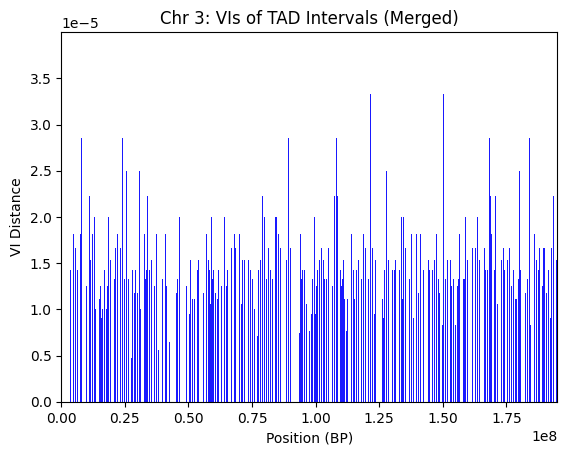

In [351]:
# plotting
chr_num = 3
# Create a figure and axis
# width = 6
# height=max(sig_vis) * 33
fig, ax = plt.subplots()

x_max = taddies_l1[-1][-1]
y_max = max(vis_l1)

print(y_max)
# Set axis limits based on maximum coordinates
if x_max is not None and y_max is not None:
    ax.set_xlim(0, x_max)
    ax.set_ylim(0, y_max)

# Iterate through coordinate ranges and draw rectangles
for i, (start, end) in enumerate(taddies_l1):
    x_length = (end - start) * 1 # artificial enlargment scaler
    y_length = vis_l1[i]

    # if (start < 350000) & (end > 800000):
    #     continue
    rectangle = Rectangle((start, 0), x_length, y_length, edgecolor='none', facecolor='blue', alpha=0.9)
    ax.add_patch(rectangle)

# Set labels and title
ax.set_xlabel('Position (BP)')
ax.set_ylabel('VI Distance')
ax.set_title('Chr '+str(chr_num)+': VIs of TAD Intervals (Merged)')
#ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
print(len(taddies_l1))
print(len(vis_l1))

print(max(vis_l1))

In [ ]:
plt.plot(vis_l1)

In [457]:
def ShuffleTADs(tad):

    cluster_lengths = tad[:, 1] - tad[:, 0]

    shuffle = np.random.choice(cluster_lengths, size = len(cluster_lengths), replace = False)

    starts = np.append(start, np.cumsum(shuffle) + start)
    ends = np.cumsum(shuffle) + start

    return np.vstack((starts[0 : len(starts) - 1], ends)).T



In [458]:
shuffle_tad_test = np.array([[13030000, 13140000],
                       [13140000, 13150000],
 [13150000, 13340000],
 [13340000, 13510000],
 [13510000, 13700000]])

start = shuffle_tad_test[0][0]
end = shuffle_tad_test[-1][-1]

cluster_lengths = shuffle_tad_test[:, 1] - shuffle_tad_test[:, 0]

print(ShuffleTADs(shuffle_tad_test))


[[13030000 13040000]
 [13040000 13230000]
 [13230000 13340000]
 [13340000 13510000]
 [13510000 13700000]]
